# Image Classification Using BOWV

We'll use TF Flowerss dataset under tensorflow which has 5 classes with ~3000 trains samples and ~700 test samples. First we'll make descriptors clustors with NearestNeighbors and then use kNN to predict which of the descriptors clustor it belongs to most and based on that we'll classify the image. One simple advantage of using this method could be less computation requirements(no GPU needed) but sacrifices on accuracy compared to deep learning methods. 
We'll be doing

*   Make dataset.
*   Make lists of descriptors( to extract local features using ORB).
*   Use K-mean to make clusters of these extracted features.
*   Build histograms of train images( these contain feature count of same cluster in a image).
*   Fit KNN on these histograms to predict on unseen image.
*  Predict on test set with KNN.

In [90]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.figsize"] = (10,5)
seed = 42

# Prepare dataset

In [91]:
dataset = tfds.load('TFFlowers', split='train',as_supervised=True, shuffle_files=True)
print('Total Train samples:', len(dataset))

Total Train samples: 3670


In [92]:
images = []
labels = []
for image,label in tfds.as_numpy(dataset):
  images.append(image)
  labels.append(label)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=seed)
print("Train, Test size", len(y_train), len(y_test))
print("Image shape", x_train[0].shape)
labels_series = pd.Series(labels)
print("Total labels", labels_series.nunique())
print("Labels dist")
labels_series.value_counts()

Train, Test size 2936 734
Image shape (240, 320, 3)
Total labels 5
Labels dist


0    898
2    799
3    699
4    641
1    633
dtype: int64

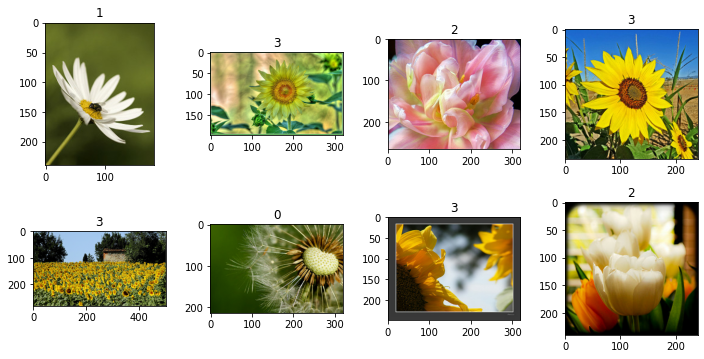

In [93]:
# show some dataset examples

ROWS, COLS = 2, 4
samples = []
labels = []

sample_ds = tfds.as_numpy(dataset.take(ROWS*COLS))
sample_ds = [[image,label] for image,label in sample_ds]

f, axs = plt.subplots(ROWS,COLS)
f.tight_layout()
a= 0

for i in range(ROWS):
  for j in range(COLS):
    axs[i,j].imshow(sample_ds[a][0])
    axs[i,j].set_title(sample_ds[a][1])
    a+=1

# Extract Descriptors

In [94]:
# make list of descriptors

descriptors_list = []
descriptors_list_rs = []
new_labels = []

orb = cv2.ORB_create(200) # max 200 descriptors

for image, label in zip(x_train, y_train):
  # image = cv2.resize(image,(200,200))
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, descriptor = orb.detectAndCompute(gray, None)
  if descriptor is not None:
    descriptors_list.extend(descriptor)
    descriptors_list_rs.append(np.array(descriptor))
    new_labels.append(label)

descriptors_array = np.array(descriptors_list).astype(np.float32) 
print(descriptors_array.shape)    

(547896, 32)


# Make clusters with KMeans

In [95]:
# cluster the descriptors to 100 components

number_of_k = 100

kmeans = KMeans(number_of_k, n_jobs=-1)
kmeans = kmeans.fit(descriptors_array)

# Build histograms of features

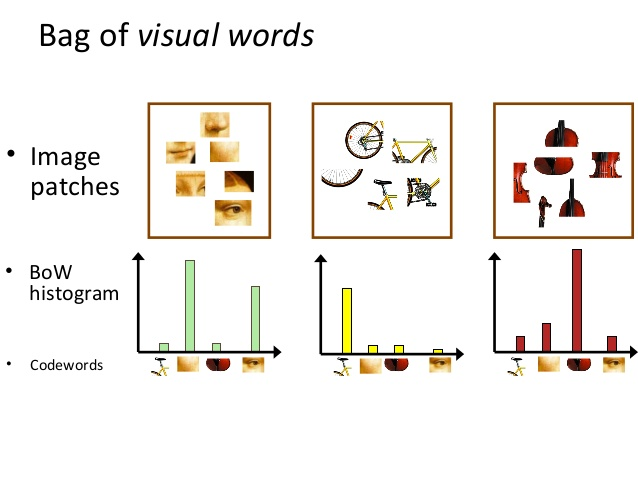

We extract descriptors (image patches) then convert them to histograms by assinging them to thier cluster center. The number of repitations of these features is BOW histogram.

In [96]:
def make_histogram_features(descriptors_list):
    features = np.zeros([len(descriptors_list), number_of_k])
    for i in range(len(descriptors_list)): # 1 example
        for j in range(len(descriptors_list[i])): # its descriptor (1, 32) shape
            desc = descriptors_list[i][j]
            desc = np.array(desc).reshape(1, desc.shape[0])
            closest_cluster_index = kmeans.predict(desc)
            features[i][closest_cluster_index] += 1.0 # frequency of closest to clusters centers(y-axis)
    return features

In [97]:
features = make_histogram_features(descriptors_list_rs)
std_sclr = StandardScaler().fit(features)
features = std_sclr.transform(features)
print(features.shape)

(2936, 100)


What we did here is we extracted features(descriptors), made cluster of them with kmeans and assgined all extracted features(descriptors) to thier respective cluster(cluster centers) by predicting with kmeans. Which is what now is the BOW features. 

# Fit KNN on these Histograms

In [107]:
# fit knn to pick k neighbor feature match

neighbor = KNeighborsClassifier(n_neighbors = 100) # 50 nearest features
neighbor = neighbor.fit(features, new_labels)

# Predict on Test set

In [104]:
# find the neighbors distance that we will use to predict

descriptors_list_test = []
test_labels = []

for image, label in zip(x_test, y_test):

  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # image = cv2.resize(image, (150, 150))
  _, desc = orb.detectAndCompute(image, None)
  if desc is not None:
    descriptors_list_test.append(desc)
    test_labels.append(label)

test_features = make_histogram_features(descriptors_list_test)
test_features = std_sclr.transform(test_features) 

In [108]:
y_preds = []
for hist in test_features:
  pred = neighbor.predict(hist.reshape(1, -1))
  y_preds.append(pred) 

# Show Results

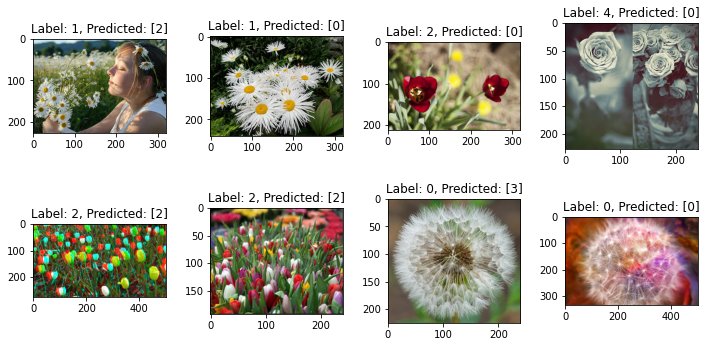

In [101]:
# show result

ROWS, COLS = 2, 4
samples = []
labels = []

f, axs = plt.subplots(ROWS,COLS)
f.tight_layout()
a= 0

for i in range(ROWS):
  for j in range(COLS):
    axs[i,j].imshow(x_test[a])
    axs[i,j].set_title(f"Label: {test_labels[a]}, Predicted: {y_preds[a]}")
    a+=1

As a results this is a very complex task for BOWV classification due to lots of similarity between images from different classes.

Predicted 267 correct of 734
Accuracy: 36.37602179836512


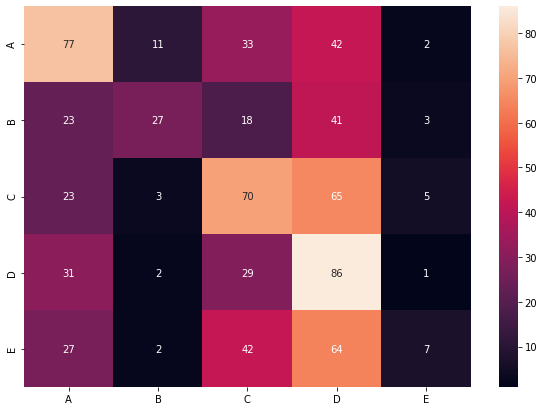

In [109]:
# print results

correct = 0
for i,j in zip(test_labels, y_preds):
  if i == j:
    correct+=1
    
print('Predicted {0} correct of {1}'.format(correct, len(test_labels)))
print('Accuracy:', correct/len(test_labels)*100)

cm = confusion_matrix(test_labels, y_preds)
df_cm = pd.DataFrame(cm, index = [i for i in "ABCDE"],
                  columns = [i for i in "ABCDE"])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

Summary:
We achieved an accuracy of 36 percent with this method. This is complex task for this method, on such complex images with heavy backgrounds this method is the best to pick. To further improve we can:
*  Use Deep Learning.
*  Use more training data.
*  More clustures of descriptors.
*  Use RandomizedSearchCV to search hyperparameters(n_clusters, n_nieghbors of KNN, KMeans).